In [28]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.visualization import plot_histogram
from qiskit.algorithms.optimizers import COBYLA

from qiskit import *
import qiskit.quantum_info as qi
from qiskit.tools.visualization import plot_histogram
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import *
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
pi = math.pi

## Biased Pauli Noise
Here we will be considering Biased Pauli


In [29]:
noise_model = NoiseModel()

p_err = 0.02
b_err = 0.0050
error_1q = pauli_error([('I',1-p_err-b_err),('X',p_err/3),('Y',p_err/3),('Z',p_err/3+b_err)]) # 1 qubit Biased Pauli error
noise_model.add_all_qubit_quantum_error(error_1q, ['delay']) 

backend = AerSimulator(noise_model=noise_model)

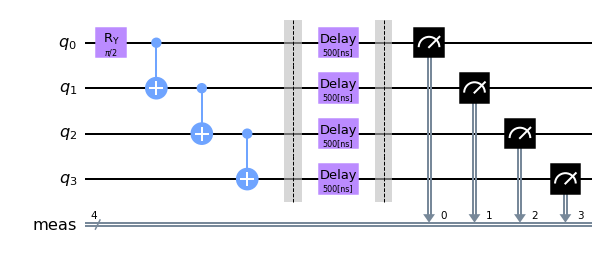

In [30]:
def U_prep(n_qubits,theta):
  qc = QuantumCircuit(n_qubits)
  qc.ry(theta,0)
  for qubit in range(n_qubits-1):
    qc.cx(qubit,qubit+1)
  qc.barrier()
  return qc

qc_without_hadamard = U_prep(4,pi/2)
qc_without_hadamard.delay(500,unit='ns')
qc_without_hadamard.measure_all()
qc_without_hadamard.draw('mpl')

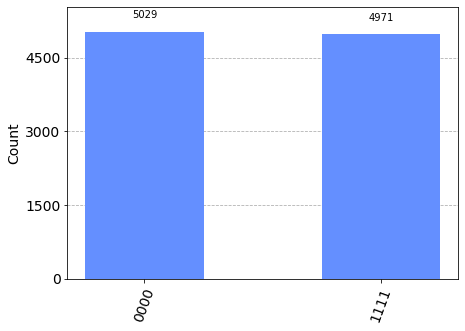

In [31]:
#Backend without Noise
results_ideal = AerSimulator().run(qc_without_hadamard,shots=10000).result()
counts_ideal = results_ideal.get_counts()
plot_histogram(counts_ideal)


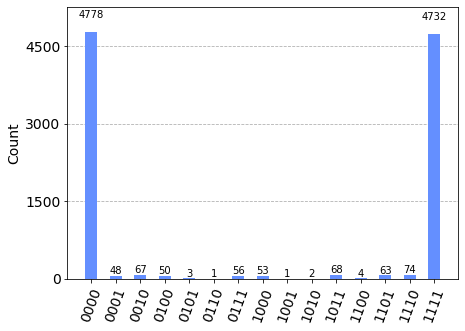

In [32]:
#Backend with noise
counts_without_hadamard = backend.run(qc_without_hadamard,shots=10000).result().get_counts()
plot_histogram(counts_without_hadamard)

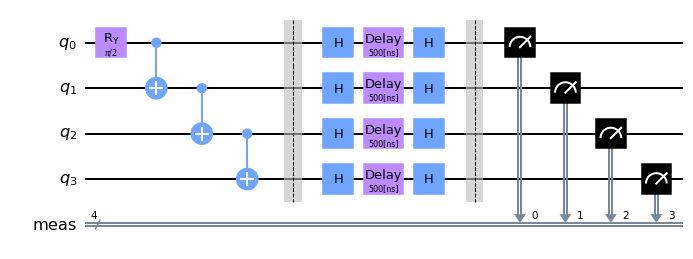

In [33]:
def padded_circuit(n_qubits,theta,delay):
  qc = U_prep(n_qubits,theta)

  for qubit in range(n_qubits):
    qc.h(qubit)
    qc.delay(delay,qubit,unit='ns')
    qc.h(qubit)
  qc.measure_all()
  return qc

qc_with_hadamard = padded_circuit(4,pi/2, 500)
qc_with_hadamard.draw('mpl')


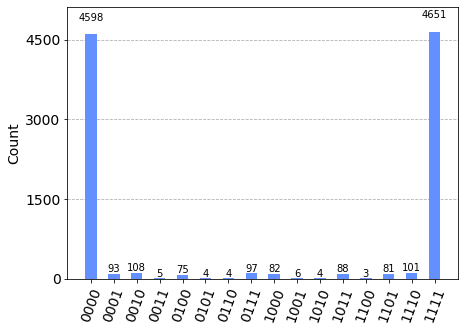

In [34]:
#Backend with Noise and padding both sides with the Hadamard gate
counts_with_hadamard = backend.run(qc_with_hadamard,shots=10000).result().get_counts()
plot_histogram(counts_with_hadamard)

In [35]:
# If state is not in the set of valid states, ouput is erroneous
def cost(counts):
  invalid_states_count = 0
  diff = 0
  counts = dict(counts)
  for state in counts.keys():
    if (state != '0000') and (state != '1111'):
      invalid_states_count += counts[state]
    # probability of getting the other 8 valid states is 5000/10000
    else:
        wt = counts[state]-5000
        if (wt >= 0):
            diff += wt # we got a valid state but how far is it from the ideal value? i.e deviation from correct value
  total_error = round((invalid_states_count + diff)/10000 , 4 )
  return {'invalid_states_count':invalid_states_count, 'deviation' : diff, 'error':total_error }


In [36]:
# counts = backend.run(qc,shots=10000).result().get_counts()
print(f"Error without noise: {cost(counts_ideal)}")
print(f"Error with noise without hadamard: {cost(counts_without_hadamard)}")
print(f"Error with noise with hadamard: {cost(counts_with_hadamard)}")

Error without noise: {'invalid_states_count': 0, 'deviation': 29, 'error': 0.0029}
Error with noise without hadamard: {'invalid_states_count': 490, 'deviation': 0, 'error': 0.049}
Error with noise with hadamard: {'invalid_states_count': 751, 'deviation': 0, 'error': 0.0751}


### Addition of hadamard gate has increased the error rate

In [37]:
# Complete this function
def pad_circuits_with_gates(n_qubits,theta,delay):  
  qc = U_prep(n_qubits,theta)
  range_low, increment = 0, pi/32
  range_high = 2*pi - increment
  circuits = []
 
  
  angle1 = range_low
  while(angle1 <= range_high): # u = rx, v = rx
    angle2 = range_low
    while(angle2 <= range_high):

      qc_pad = qc.copy()

      for qubit in range(n_qubits):     # u = rx
        qc_pad.rx(angle1,qubit)

      qc_pad.delay(delay,unit='ns')

      for qubit in range(n_qubits):     # v = rx
        qc_pad.rx(angle2,qubit)
      
      qc_pad.measure_all()
      circuits.append((qc_pad, angle1,angle2))
      # a1.append(angle1)
      # a2.append(angle2)
      angle2 += increment
    angle1 += increment

  angle1 = range_low
  while(angle1 <= range_high): # u = rx, v = ry
    angle2 = range_low
    while(angle2 <= range_high):

      qc_pad = qc.copy()

      for qubit in range(n_qubits):     # u = rx
        qc_pad.rx(angle1,qubit)

      qc_pad.delay(delay,unit='ns')

      for qubit in range(n_qubits):     # v = ry
        qc_pad.ry(angle2,qubit)
      
      qc_pad.measure_all()
      circuits.append((qc_pad, angle1,angle2))
      # a1.append(angle1)
      # a2.append(angle2)
      angle2 += increment
    angle1 += increment

  angle1 = range_low
  while(angle1 <= range_high): # u = ry, v = rx
    angle2 = range_low
    while(angle2 <= range_high):

      qc_pad = qc.copy()

      for qubit in range(n_qubits):     # u = ry
        qc_pad.ry(angle1,qubit)

      qc_pad.delay(delay,unit='ns')

      for qubit in range(n_qubits):     # v = rx
        qc_pad.rx(angle2,qubit)
      
      qc_pad.measure_all()
      circuits.append((qc_pad, angle1,angle2))
      # a1.append(angle1)
      # a2.append(angle2)
      angle2 += increment
    angle1 += increment

  angle1 = range_low
  while(angle1 <= range_high): # u = ry, v = ry
    angle2 = range_low
    while(angle2 <= range_high):

      qc_pad = qc.copy()

      for qubit in range(n_qubits):     # u = ry
        qc_pad.ry(angle1,qubit)

      qc_pad.delay(delay,unit='ns')

      for qubit in range(n_qubits):     # v = ry
        qc_pad.ry(angle2,qubit)
      
      qc_pad.measure_all()
      circuits.append((qc_pad, angle1,angle2))
      # a1.append(angle1)
      # a2.append(angle2)
      angle2 += increment
    angle1 += increment

  return circuits

ckts = pad_circuits_with_gates(4,pi/2,500)

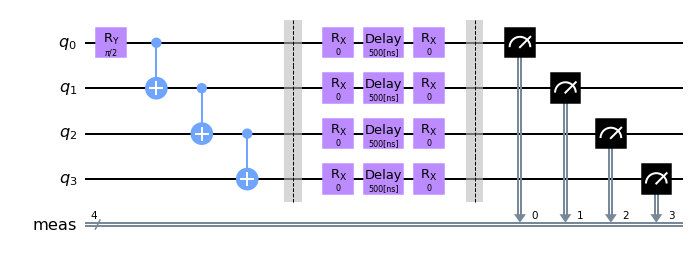

In [47]:
ckts[0][0].draw('mpl')

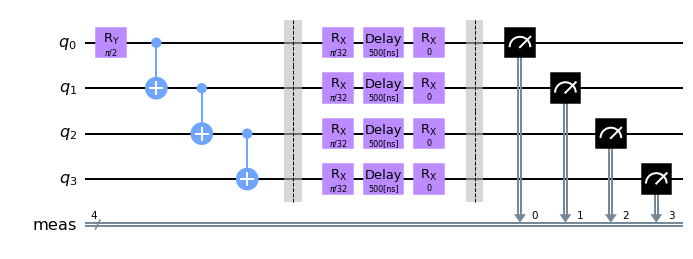

In [39]:
ckts[64][0].draw('mpl')

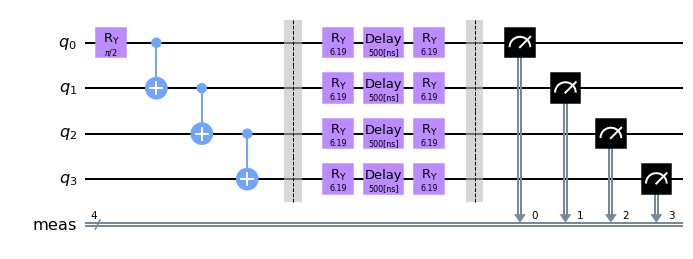

In [40]:
ckts[16383][0].draw('mpl')

In [41]:
def getError(ckt_info):
  return ckt_info['error']

In [48]:
from tqdm import tqdm
min_error = 999999
min_err_info = None
min_ckt = None
theta = []
error = []

for ckt in tqdm(range(len(ckts))):
  qc = ckts[ckt][0]
  counts = backend.run(qc,shots=10000).result().get_counts()
  err = cost(counts)
  err['index'] = ckt
  error.append(err)

error.sort(key=getError)


100%|██████████| 16384/16384 [02:42<00:00, 100.97it/s]


In [50]:
print(error[0])

{'invalid_states_count': 473, 'deviation': 0, 'error': 0.0473, 'index': 4065}


Optimal circuit

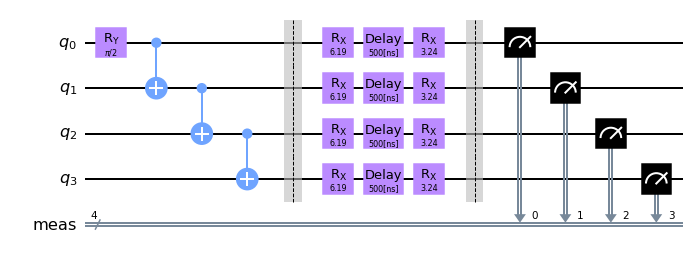

In [51]:
opt_idx = error[0]['index']
min_err_ckt = ckts[opt_idx][0]
min_err_ckt.draw('mpl')

In [52]:
errors = []
for i in range(len(ckts)):
  errors.append(error[i]['error'])

Plotting graphs

In [53]:
# for creating a responsive plot
%matplotlib widget

# Seprrating angles of U and V
x = np.array([ckt[:][1] for ckt in ckts ]) # U angle
x = np.array_split(x, len(x) / 4096)

y = np.array([ckt[:][2] for ckt in ckts ]) # V angle
y = np.array_split(y, len(y) / 4096)

z = np.array_split(np.array(errors), len(error)/4096 )

Error without applying any gate {'invalid_states_count': 490, 'deviation': 0, 'error': 0.049}
Error after applying hadamard gate {'invalid_states_count': 751, 'deviation': 0, 'error': 0.0751}
Minimum error we found {'invalid_states_count': 473, 'deviation': 0, 'error': 0.0473, 'index': 4065}


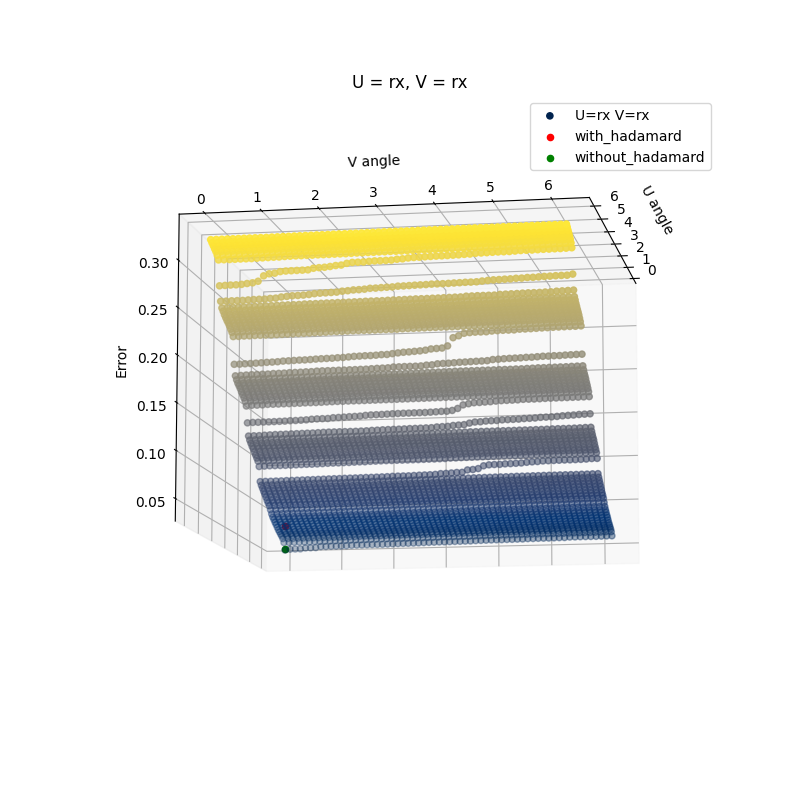

In [54]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.grid()
ax.set_title('U = rx, V = rx')
ax.set_xlabel('U angle')
ax.set_ylabel('V angle')
ax.set_zlabel('Error')

l1 = ax.scatter(x[0], y[0], z[0], c=z[0], cmap='cividis', label='U=rx V=rx')
l2 = ax.scatter(0,0,cost(counts_with_hadamard)['error'], color='red', label='with_hadamard')
l3 = ax.scatter(0,0,cost(counts_without_hadamard)['error'], color='green', label='without_hadamard')
ax.legend(handles=[l1, l2, l3])
ax.view_init(elev=-10, azim=10)

print(f"Error without applying any gate {cost(counts_without_hadamard)}")
print(f"Error after applying hadamard gate {cost(counts_with_hadamard)}")
print(f"Minimum error we found {error[0]}")
plt.show()

Error without applying any gate {'invalid_states_count': 490, 'deviation': 0, 'error': 0.049}
Error after applying hadamard gate {'invalid_states_count': 751, 'deviation': 0, 'error': 0.0751}
Minimum error we found {'invalid_states_count': 473, 'deviation': 0, 'error': 0.0473, 'index': 4065}


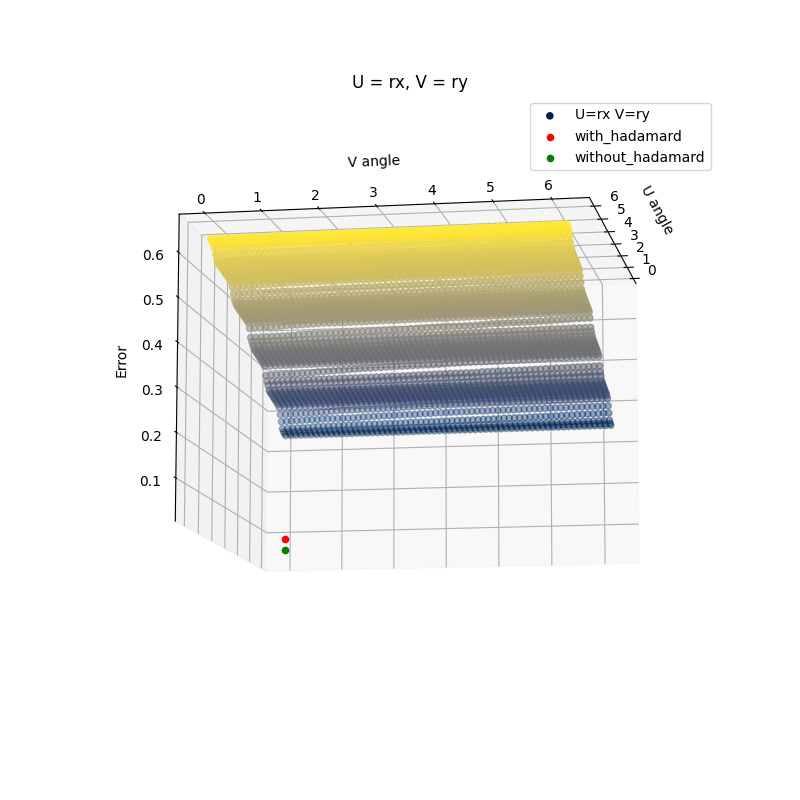

In [55]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.grid()
ax.set_title('U = rx, V = ry')
ax.set_xlabel('U angle')
ax.set_ylabel('V angle')
ax.set_zlabel('Error')

l1 = ax.scatter(x[1], y[1], z[1], c=z[1], cmap='cividis', label='U=rx V=ry')
l2 = ax.scatter(0,0,cost(counts_with_hadamard)['error'], color='red', label='with_hadamard')
l3 = ax.scatter(0,0,cost(counts_without_hadamard)['error'], color='green', label='without_hadamard')
ax.legend(handles=[l1, l2, l3])
ax.view_init(elev=-10, azim=10)
print(f"Error without applying any gate {cost(counts_without_hadamard)}")
print(f"Error after applying hadamard gate {cost(counts_with_hadamard)}")
print(f"Minimum error we found {error[0]}")
plt.show()

Error without applying any gate {'invalid_states_count': 490, 'deviation': 0, 'error': 0.049}
Error after applying hadamard gate {'invalid_states_count': 751, 'deviation': 0, 'error': 0.0751}
Minimum error we found with U=ry V=rx {'invalid_states_count': 473, 'deviation': 0, 'error': 0.0473, 'index': 4065}


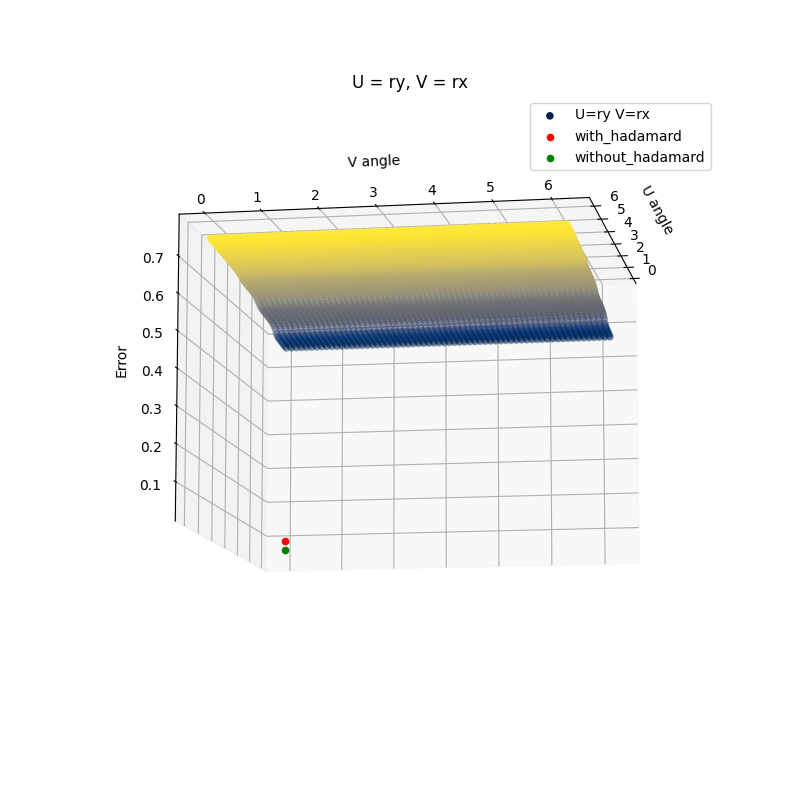

In [56]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.grid()
ax.set_title('U = ry, V = rx')
ax.set_xlabel('U angle')
ax.set_ylabel('V angle')
ax.set_zlabel('Error')

l1 = ax.scatter(x[2], y[2], z[2], c=z[2], cmap='cividis', label='U=ry V=rx')
l2 = ax.scatter(0,0,cost(counts_with_hadamard)['error'], color='red', label='with_hadamard')
l3 = ax.scatter(0,0,cost(counts_without_hadamard)['error'], color='green', label='without_hadamard')
ax.legend(handles=[l1, l2, l3])
ax.view_init(elev=-10, azim=10)
print(f"Error without applying any gate {cost(counts_without_hadamard)}")
print(f"Error after applying hadamard gate {cost(counts_with_hadamard)}")
print(f"Minimum error we found with U=ry V=rx {error[0]}")
plt.show()

Error without applying any gate {'invalid_states_count': 490, 'deviation': 0, 'error': 0.049}
Error after applying hadamard gate {'invalid_states_count': 751, 'deviation': 0, 'error': 0.0751}
Minimum error we found with U=ry V=rx {'invalid_states_count': 473, 'deviation': 0, 'error': 0.0473, 'index': 4065}


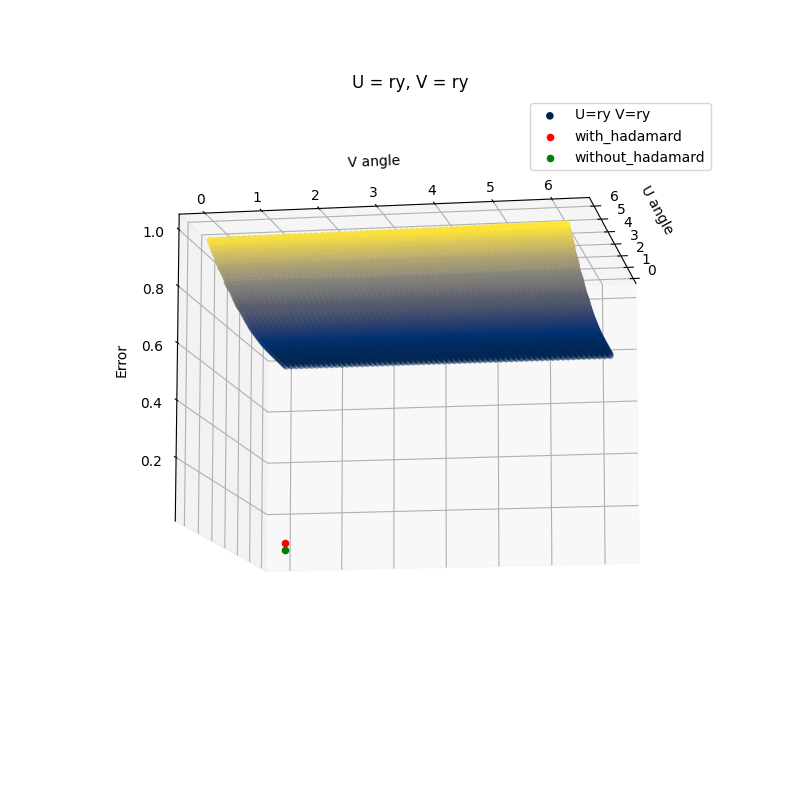

In [57]:
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.grid()
ax.set_title('U = ry, V = ry')
ax.set_xlabel('U angle')
ax.set_ylabel('V angle')
ax.set_zlabel('Error')

l1 = ax.scatter(x[3], y[3], z[3], c=z[3], cmap='cividis', label='U=ry V=ry')
l2 = ax.scatter(0,0,cost(counts_with_hadamard)['error'], color='red', label='with_hadamard')
l3 = ax.scatter(0,0,cost(counts_without_hadamard)['error'], color='green', label='without_hadamard')
ax.legend(handles=[l1, l2, l3])
ax.view_init(elev=-10, azim=10)
print(f"Error without applying any gate {cost(counts_without_hadamard)}")
print(f"Error after applying hadamard gate {cost(counts_with_hadamard)}")
print(f"Minimum error we found with U=ry V=rx {error[0]}")
plt.show()

## Now we wish to change the noise model

In [58]:
from biased_pauli_template import biased_pauli as bp
min_ckt, min_err_info, min_error = bp(p_err=0.03, b_err=0.005, delay_time=500)

100%|██████████| 16384/16384 [02:42<00:00, 100.55it/s]


In [59]:
print(min_err_info)

{'invalid_states_count': 738, 'deviation': 0, 'error': 0.0738, 'index': 6176}


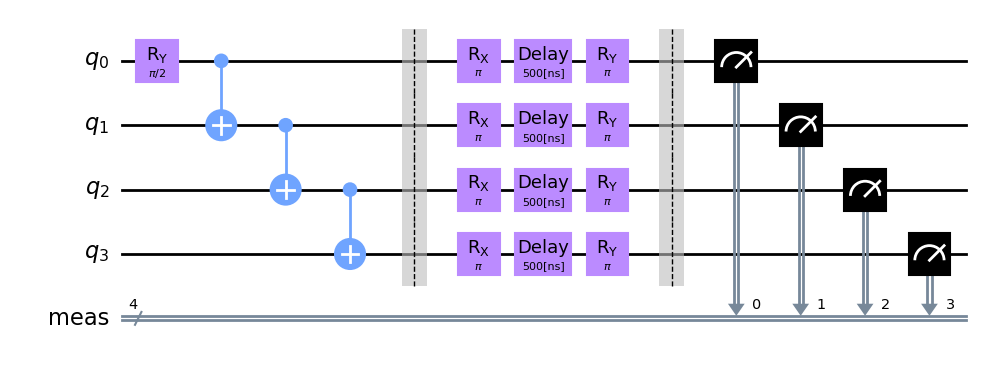

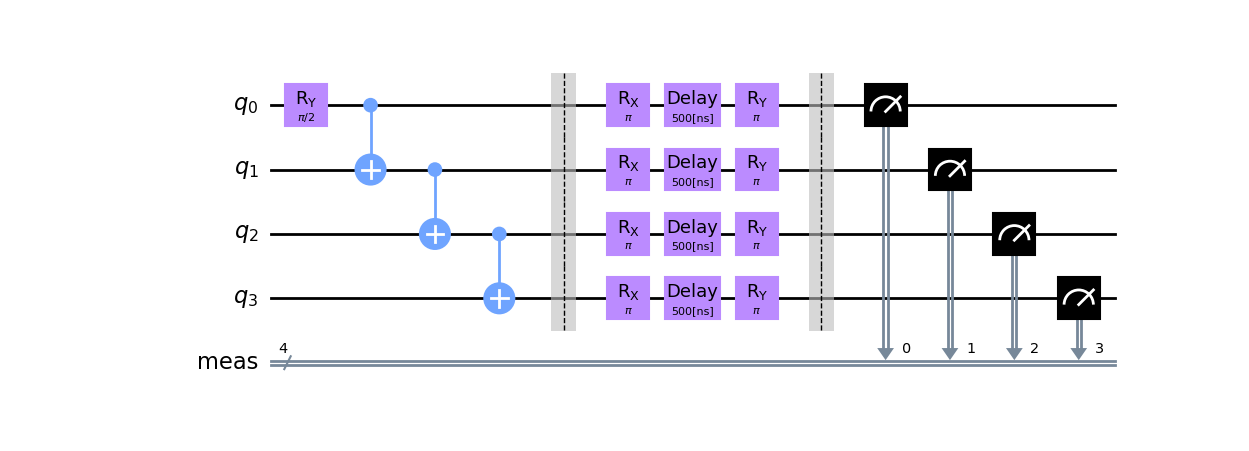

In [60]:
min_ckt.draw('mpl')

## And we run our optimal circuit with different levels of noise and delay

In [ ]:
from tqdm import tqdm
ckts_list = []
error_list = []
error_dict_list = []

for delay in tqdm(range(500,1200,100)):
  noise_prob = 0.005
  while(noise_prob<=0.05):
    print(f"@@@@@ noise_prob = {noise_prob} delay = {delay}")
    min_ckt, min_err_info, min_error = bp(noise_prob, b_err, delay)
    ckts_list.append(min_ckt)
    error_dict_list.append(min_err_info)
    error_list.append(min_error)
    noise_prob += 0.005